In [1]:
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def convert_dicta(dicta):
    frames = [convert_frame(dicta[i]) for i in dicta]
    return frames

def convert_frame(frame):
    convert = {}
    for keypoint in frame:
        convert[keypoint["idx"]] = keypoint["keypoints"]
    return convert

with open("assets/alphapose-results-forvis-tracked.json","r") as file:
    dicta = json.load(file)
    
alpha_pose_dict = convert_dicta(dicta)

In [4]:
def iuv2atlas(frame,iuv,inds):
    inds[np.logical_and(inds==0,
                       iuv.any(axis=-1))] = 3
    atlas = np.zeros((3,24,256,256,3))
    atlas[:] = -1
    for detect_index in range(1,4):
        frame_detected = frame[inds==detect_index]
        iuv_detected = iuv[inds==detect_index]
        I,U,V = iuv_detected.transpose()
        atlas[detect_index-1,I-1,255-V,U,:] = frame_detected
    return atlas.astype(int)

def most_frequent(List): 
    return max(set(List), key = List.count)

def get_frame_DensePose_index(index, inds):
    alpha_pose = np.array(alpha_pose_dict[index][1])
    x = alpha_pose[range(0,len(alpha_pose),3)]
    y = alpha_pose[range(1,len(alpha_pose),3)]
    points = np.vstack((y,x)).T.astype(int)
    votes = []
    for i in points:
        votes.append(inds[i[0],i[1]])
    vote = most_frequent(votes)
    if vote==0:
        vote = 3
    return vote

def combine_atlas(atlas):
    combined = np.zeros((256*6,256*4,3))
    for row in range(6):
        for col in range(4):
            combined[row*256:(row+1)*256,
                     col*256:(col+1)*256,:] =\
                     atlas[row+col*6,:,:,:]
    return combined


def get_DensePose_data(index):
    frame = cv2.imread("assets/frames/" + str(index) + ".jpg")[:,:,::-1]
    iuv = cv2.imread("assets/DensePose_out/" + str(index) + "_IUV.png")
    inds= cv2.imread("assets/DensePose_out/" + str(index) + "_INDS.png",0)
    return frame, iuv, inds


def get_frame_texture(index):
    frame, iuv, inds = get_DensePose_data(index)
    DP_ind = get_frame_DensePose_index(index, inds)
    atlas = iuv2atlas(frame,iuv,inds)
    return atlas[DP_ind-1]

In [13]:
textures = []
for i in range(0,512,2):
    try:
        if i%10==0:
            print(i)
        textures.append(get_frame_texture(i))
    except:
        continue

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510


In [14]:
textures = np.array(textures[1:]).astype(float)
textures[textures==-1] = np.nan


NameError: name 'arr' is not defined

In [93]:
blend = np.nanmean(textures,axis=0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [17]:
import pickle
with open("atlas.pkl","wb") as f:
    pickle.dump(blend,f)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


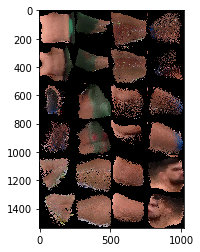

In [20]:
plt.imshow(combine_atlas(blend).astype(int))

In [18]:
import matplotlib.pyplot as plt

precomputed = pickle.load(open("assets/textures/precomputed.pkl","rb"))

def IUV2UV2(i,u,v):
    u = int(u*256)
    v = int(v*256)
    return precomputed[(i-1)*256*256+u*256+v][1]
    
def atlas_to_texture(atlas_im):
    texture = np.zeros((256, 256,3))
    size_i,size_u,size_v,_ = atlas_im.shape
    for i in range(size_i):
        print(i)
        for u in range(size_u):
            for v in range(size_v):
                UV_coord = IUV2UV2(i+1,u/size_u,v/size_v)
                texture[int(UV_coord[0]*255),int(UV_coord[1]*255),:]=\
                           atlas_im[i,v,u,:] 
    return texture.transpose([1,0,2])

In [94]:
new_image = atlas_to_texture(blend)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


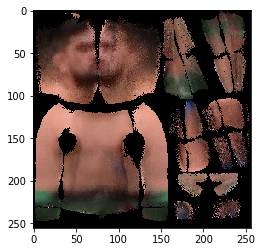

In [95]:
plt.imshow(new_image.astype(int))

In [24]:
cv2.inpaint(new_image)

TypeError: inpaint() missing required argument 'inpaintMask' (pos 2)

In [96]:
mask=np.isnan(new_image)
new_image[mask]=0

In [52]:
cv2.inpaint(new_image.astype(int),(mask*255).all(axis=2).astype(int),3,cv2.INPAINT_TELEA)

error: OpenCV(3.4.2) /Users/travis/build/skvark/opencv-python/opencv/modules/photo/src/inpaint.cpp:757: error: (-210:Unsupported format or combination of formats) 8-bit, 16-bit unsigned or 32-bit float 1-channel and 8-bit 3-channel input/output images are supported in function 'cvInpaint'


In [50]:
mask.shape

(256, 256, 3)

In [53]:
textures.shape

(254, 24, 256, 256, 3)

In [60]:
from skimage.restoration import inpaint

In [59]:
!pip3 install scikit-image

  Using cached https://files.pythonhosted.org/packages/6f/ee/37254a96f7910f4caa830faad72a2fb144e1cebe62a5abbe50a80e942094/scikit_image-0.15.0-cp37-cp37m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl
    100% |████████████████████████████████| 1.8MB 5.4MB/s ta 0:00:011
  Using cached https://files.pythonhosted.org/packages/af/0a/943c965d372dae0b1f1482677d29030ab834351a61a9a632fd62f27f1523/imageio-2.5.0-py3-none-any.whl
    100% |████████████████████████████████| 3.9MB 4.5MB/s ta 0:00:011
  Using cached https://files.pythonhosted.org/packages/1e/c5/7267d62da464851bd4b63f0da321acd949421079db341c3d059a31bbcb6a/PyWavelets-1.0.3-cp37-cp37m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl
  Running setup.py install for networkx ... done
You are using pip version 19.0.3, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [97]:
inpainted = inpaint.inpaint_biharmonic(new_image, mask.all(axis=2),
                                          multichannel=True)

In [64]:
new_image.shape

(256, 256, 3)

In [65]:
mask.shape

(256, 256, 3)

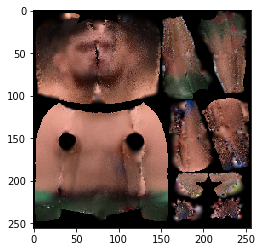

In [98]:
plt.imshow(inpainted.astype(int))

In [71]:
dir(inpaint)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_get_neighborhood',
 '_inpaint_biharmonic_single_channel',
 'inpaint_biharmonic',
 'label',
 'laplace',
 'ndi',
 'np',
 'skimage',
 'sparse',
 'spsolve']

In [83]:
plt.imsave(inpainted,"funny_text.png")

TypeError: cannot perform reduce with flexible type

In [79]:
to_be_saved = inpainted.astype(int)

In [80]:
to_be_saved

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]])

In [81]:
np.isnan(to_be_saved)

array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False,

In [90]:
np.sum(np.isnan(inpainted.astype(int)))

0

In [92]:
cv2.imwrite("bla.png", inpainted.astype(int)[:,:,::-1])

True